In [1]:
from sklearn.metrics import recall_score
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
from collections import Counter
from tqdm import tqdm
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sktime.classification.kernel_based import RocketClassifier

In [4]:
files_dir = '../../teams/DSC180B_WI22_A00/b11group2/actigraphy/'
all_files = os.listdir(files_dir)
# Might need to change these numbers 
N_train = 1500
# Reading all the files
train_data = [pd.read_csv(files_dir+i) for i in all_files[:N_train]]
test_data = [pd.read_csv(files_dir+i) for i in all_files[N_train:]]

In [5]:
def data_preproc(raw_df):
    '''Takes in the raw df and outputs df ready to put into the classifier'''
    
    df = raw_df.drop(['pid', 'sawa2'], axis = 1)

    df = df.loc[df.interval != 'EXCLUD'].reset_index(drop = True)

    df['interval_num'] = df.interval.replace({'ACTIVE': 3, 'REST': 1, 'REST-S': 0}) # so the differences are unique

    epochs_in_each_interval = (df.loc[df.interval_num.diff() != 0, :] # epochs where state changed
                               .line
                               .diff()) # number of epochs in each state, starting from active

    # interval_epochs eventually contains 1) indicies where state changes, 2) what interval starts at that epoch,  
    # 3) num of epochs in the state before it and 4) the num of epochs in that state itself
    interval_epochs = (df.iloc[epochs_in_each_interval.index,:].interval_num.to_frame()
                       .join(epochs_in_each_interval).reset_index())
    interval_epochs.columns = ['index', 'interval_num', 'num_epochs_before_interval']
    interval_epochs['num_epochs_in_interval'] = interval_epochs.num_epochs_before_interval[1:].reset_index(drop=True)

    # indicies where active (3) starts or sleeping (0) starts
    active_sleep_idx = list(interval_epochs.loc[(interval_epochs.interval_num == 0) | 
                                                (interval_epochs.interval_num == 3)]['index'])

    # indicies where active starts
    active_idx = interval_epochs.loc[interval_epochs.interval_num == 3].index

    sleep_eff = [] # will contain sleep efficiency for the different times that subject sleeps
    num_epochs_in_interval = interval_epochs.num_epochs_in_interval

    for i in range(len(interval_epochs)):
        if interval_epochs.iloc[i, 1] == 0:
            if interval_epochs.iloc[i-1, 1] == 1:
                sleep_eff.append(interval_epochs.iloc[i, 3]/(interval_epochs.iloc[i-1, 3]+interval_epochs.iloc[i, 3]))
            else:
                sleep_eff.append(1)
                
    # indicies where light exposure occurs before the subject sleeps (active + rest)
    awake_light_idx = []
    for i in range(interval_epochs.shape[0]):
        if interval_epochs.iloc[i, 1] == 0:
            if interval_epochs.iloc[i-1, 1] == 1:
                awake_light_idx.append(tuple((interval_epochs.iloc[i-2, 0], interval_epochs.iloc[i, 0])))
            else:
                awake_light_idx.append(tuple((interval_epochs.iloc[i-1, 0], interval_epochs.iloc[i, 0])))

                # series with series of light (this is the format that sktime dfs take)
    awake_whitelight_series = pd.Series([df.whitelight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                         for x,y in awake_light_idx]) # light for last 2 hours before sleep only
    awake_bluelight_series = pd.Series([df.bluelight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                        for x,y in awake_light_idx])
    awake_greenlight_series = pd.Series([df.greenlight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                         for x,y in awake_light_idx])
    awake_redlight_series = pd.Series([df.redlight.iloc[x:y].fillna(0).iloc[-240:].reset_index(drop=True) 
                                       for x,y in awake_light_idx])

    # each entry in column dim_xxxx is a series of light
    final_df = pd.DataFrame({"dim_white": awake_whitelight_series.values, 
                             "dim_blue": awake_bluelight_series.values,
                             "dim_green": awake_greenlight_series.values,
                             "dim_red": awake_redlight_series.values,
                             "sleep_eff": sleep_eff})

    # threshold chosen using idea that good sleep efficiency is when one sleeps in ~24 mins
    # for a sleep of 8 hrs (ratio -- 24mins/8hrs = 3mins/1hr)
    final_df["sleep_eff_cat"] = (final_df.sleep_eff >= 0.95).replace({True: "Good", False: "Bad"})

    return final_df

In [6]:
def concat_proc_data(raw_data_lst):
    '''Takes in list of raw dfs, preproccesses them and concats them.'''
    concat_df = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    for df in raw_data_lst:
        proc_data = data_preproc(df)
        concat_df = pd.concat([concat_df, proc_data])
    concat_df = concat_df.reset_index(drop = True)
    concat_df = concat_df.loc[concat_df.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    return concat_df

In [7]:
def concat_proc_data_act(raw_data_lst):
    '''Takes in list of raw dfs, preproccesses them and concats them.'''
    mean_act = pd.Series([df.activity.mean() for df in raw_data_lst])
    MEDIAN_ACTIVITY = mean_act.median()
    
    concat_df_act_less = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    concat_df_act_more = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    
    for df in raw_data_lst:
        proc_data = data_preproc(df)
        if df.activity.mean() <= MEDIAN_ACTIVITY:
            concat_df_act_less = pd.concat([concat_df_act_less, proc_data])
        else:
            concat_df_act_more = pd.concat([concat_df_act_more, proc_data])
            
    concat_df_act_less = concat_df_act_less.reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.reset_index(drop = True)
    
    concat_df_act_less = concat_df_act_less.loc[concat_df_act_less.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.loc[concat_df_act_more.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    
    return concat_df_act_less, concat_df_act_more

In [8]:
def concat_proc_data_sleep(raw_data_lst):
    '''Takes in list of raw dfs, preproccesses them and concats them.'''
    sleep_total = pd.Series([(df.interval == 'REST-S').sum() / 120 for df in train_data])
    MEDIAN_SLEEP = sleep_total.median()
    
    concat_df_act_less = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    concat_df_act_more = pd.DataFrame(columns = ["dim_white","dim_blue","dim_green","dim_red","sleep_eff","sleep_eff_cat"])
    
    for df in raw_data_lst:
        proc_data = data_preproc(df)
        if (df.interval == 'REST-S').sum() / 120 <= MEDIAN_SLEEP:
            concat_df_act_less = pd.concat([concat_df_act_less, proc_data])
        else:
            concat_df_act_more = pd.concat([concat_df_act_more, proc_data])
            
    concat_df_act_less = concat_df_act_less.reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.reset_index(drop = True)
    
    concat_df_act_less = concat_df_act_less.loc[concat_df_act_less.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    concat_df_act_more = concat_df_act_more.loc[concat_df_act_more.dim_white.apply(lambda x: len(x)) >= 240].reset_index(drop = True)
    
    return concat_df_act_less, concat_df_act_more

In [9]:
def split_X_y(df):
    '''Split X features and y outcome.'''
    return (df.iloc[:, :4], df.iloc[:, 5])

In [10]:
def most_common(lst):
#     return max(set(lst), key=lst.count)
    data = Counter(lst[::-1])
    return max(lst[::-1], key=data.get)

In [9]:
train_preproc = concat_proc_data(train_data)
test_preproc = concat_proc_data(test_data)

In [10]:
test_preproc.sleep_eff_cat.value_counts(normalize = True)

Good    0.868807
Bad     0.131193
Name: sleep_eff_cat, dtype: float64

In [16]:
corrs_green_blue = []
corrs_green_red = []
corrs_red_blue = []
corrs_white_blue = []
corrs_white_red = []
corrs_white_green = []
for i in tqdm(range(train_preproc.shape[0])):
    corrs_green_blue.append(train_preproc.dim_green[i].corr(train_preproc.dim_blue[i]))
    corrs_green_red.append(train_preproc.dim_green[i].corr(train_preproc.dim_red[i]))
    corrs_red_blue.append(train_preproc.dim_red[i].corr(train_preproc.dim_blue[i]))
    corrs_white_blue.append(train_preproc.dim_blue[i].corr(train_preproc.dim_white[i]))
    corrs_white_red.append(train_preproc.dim_white[i].corr(train_preproc.dim_red[i]))
    corrs_white_green.append(train_preproc.dim_white[i].corr(train_preproc.dim_green[i]))

100%|██████████| 12654/12654 [00:12<00:00, 1012.67it/s]


In [17]:
print(pd.Series(corrs_green_blue).dropna().abs().quantile(.025), pd.Series(corrs_green_blue).dropna().abs().quantile(.975))
print(pd.Series(corrs_green_red).dropna().abs().quantile(.025), pd.Series(corrs_green_red).dropna().abs().quantile(.975))
print(pd.Series(corrs_red_blue).dropna().abs().quantile(.025), pd.Series(corrs_red_blue).dropna().abs().quantile(.975))
print(pd.Series(corrs_white_blue).dropna().abs().quantile(.025), pd.Series(corrs_white_blue).dropna().abs().quantile(.975))
print(pd.Series(corrs_white_red).dropna().abs().quantile(.025), pd.Series(corrs_white_red).dropna().abs().quantile(.975))
print(pd.Series(corrs_white_green).dropna().abs().quantile(.025), pd.Series(corrs_white_green).dropna().abs().quantile(.975))

0.6269639270970362 0.9962928355070373
0.5030370509173947 0.9899357673955437
0.2352404791506124 0.979465538289955
0.5952986904955827 0.9949872279536573
0.6614508103224416 0.9941359621154074
0.9512654443068823 0.9998637286994772


In [18]:
print(pd.Series(corrs_green_blue).dropna().abs().quantile(.5))
print(pd.Series(corrs_green_red).dropna().abs().quantile(.5))
print(pd.Series(corrs_red_blue).dropna().abs().quantile(.5))
print(pd.Series(corrs_white_blue).dropna().abs().quantile(.5))
print(pd.Series(corrs_white_red).dropna().abs().quantile(.5))
print(pd.Series(corrs_white_green).dropna().abs().quantile(.5))

0.9366062547938862
0.8881894072085672
0.734990341243779
0.9113660159517373
0.9344267827611874
0.9950526013580665


In [38]:
train_good = train_preproc.loc[train_preproc.sleep_eff_cat == 'Good']
train_bad = train_preproc.loc[train_preproc.sleep_eff_cat == 'Bad']
train_balanced = pd.concat([train_good.sample(train_bad.shape[0]), train_bad]).reset_index(drop = True)

In [39]:
train_preproc_X, train_preproc_y = split_X_y(train_balanced)
test_preproc_X, test_preproc_y = split_X_y(test_preproc)

In [ ]:
# train_preproc_X#.dim_blue

In [40]:
# from sktime.transformations.panel.rocket import Rocket

In [15]:
rocket = RocketClassifier()
rocket.fit(train_preproc_X.dim_white.to_frame(), train_preproc_y)

with open('models/rocket_model_white_only.pkl','wb') as f:
    pickle.dump(rocket, f)
    
y_pred = rocket.predict(test_preproc_X.dim_white.to_frame())
recall_score(test_preproc_y, y_pred, pos_label = "Bad") 

0.627039627039627

In [41]:
# Load different models
with open('models/rocket_model.pkl', 'rb') as f:
    rocket_overall = pickle.load(f)

with open('models/rocket_model_blue_only.pkl', 'rb') as f:
    rocket_blue = pickle.load(f)

with open('models/rocket_model_red_only.pkl', 'rb') as f:
    rocket_red = pickle.load(f)

with open('models/rocket_model_green_only.pkl', 'rb') as f:
    rocket_green = pickle.load(f)

with open('models/rocket_model_white_only.pkl', 'rb') as f:
    rocket_white = pickle.load(f)
    
rocket_models = [rocket_overall, rocket_red, rocket_blue, rocket_green, rocket_white]

In [28]:
y_pred = rocket_models[0].predict(test_preproc_X)#.dim_white.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.6363636363636364 0.5772615276311158


In [29]:
y_pred = rocket_models[1].predict(test_preproc_X.dim_red.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.6317016317016317 0.5955649419218585


In [30]:
y_pred = rocket_models[2].predict(test_preproc_X.dim_blue.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.5920745920745921 0.5807814149947201


In [31]:
y_pred = rocket_models[3].predict(test_preproc_X.dim_green.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.6386946386946387 0.6043646603308694


In [32]:
y_pred = rocket_models[4].predict(test_preproc_X.dim_white.to_frame())
print(recall_score(test_preproc_y, y_pred, pos_label = "Bad"), recall_score(test_preproc_y, y_pred, pos_label = "Good"))

0.627039627039627 0.6156282998944034


In [46]:
original_test_X = test_preproc_X
original_test_y = test_preproc_y

In [44]:
def model_preds(X):
    preds_1 = rocket_models[1].predict(X.dim_red.to_frame())
    preds_2 = rocket_models[2].predict(X.dim_blue.to_frame())
    preds_3 = rocket_models[3].predict(X.dim_green.to_frame())
    preds_4 = rocket_models[4].predict(X.dim_white.to_frame())
    pred_df = pd.DataFrame({'red_pred': preds_1, 
                            'blue_pred': preds_2, 
                            'green_pred': preds_3, 
                            'white_pred': preds_4})
    model_preds = pred_df.apply(lambda row: most_common(list(row)), axis = 1)
    return pred_df

In [47]:
model_preds_f = model_preds(original_test_X)

In [55]:
red_recalls = []
blue_recalls = []
green_recalls = []
for _ in tqdm(range(100)):
    test_preproc_samples = [test_preproc.sample(frac = 0.1, replace = True) for _ in range(3)]
    test_preproc_X_y_samples = [split_X_y(df) for df in test_preproc_samples]
    preds_red_samp = rocket_models[1].predict(test_preproc_X_y_samples[0][0].dim_red.to_frame())
    preds_blue_samp = rocket_models[2].predict(test_preproc_X_y_samples[1][0].dim_blue.to_frame())
    preds_green_samp = rocket_models[3].predict(test_preproc_X_y_samples[2][0].dim_green.to_frame())
    red_recalls.append(recall_score(test_preproc_X_y_samples[0][1], preds_red_samp, pos_label = 'Bad'))
    blue_recalls.append(recall_score(test_preproc_X_y_samples[1][1], preds_blue_samp, pos_label = 'Bad'))
    green_recalls.append(recall_score(test_preproc_X_y_samples[2][1], preds_green_samp, pos_label = 'Bad'))

100%|██████████| 100/100 [40:08<00:00, 24.08s/it]


(array([ 2.,  5.,  4., 12., 17., 13., 22., 13.,  5.,  7.]),
 array([0.43181818, 0.45974747, 0.48767677, 0.51560606, 0.54353535,
        0.57146465, 0.59939394, 0.62732323, 0.65525253, 0.68318182,
        0.71111111]),
 <BarContainer object of 10 artists>)

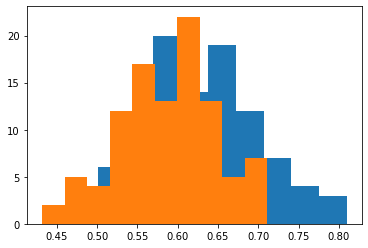

In [65]:
plt.hist(pd.Series(red_recalls))
plt.hist(pd.Series(blue_recalls))

In [59]:
ks_2samp(red_recalls, blue_recalls)

KstestResult(statistic=0.26, pvalue=0.002219935934558366)

(array([ 2.,  4., 10., 14., 16., 18., 17.,  8.,  6.,  5.]),
 array([0.44444444, 0.47954545, 0.51464646, 0.54974747, 0.58484848,
        0.61994949, 0.65505051, 0.69015152, 0.72525253, 0.76035354,
        0.79545455]),
 <BarContainer object of 10 artists>)

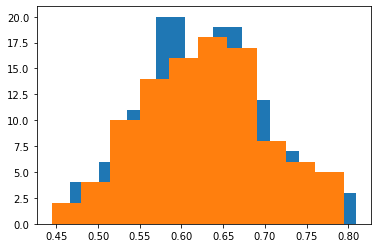

In [66]:
plt.hist(pd.Series(red_recalls))
plt.hist(pd.Series(green_recalls))

In [68]:
ks_2samp(green_recalls, red_recalls)

KstestResult(statistic=0.08, pvalue=0.9084105017744525)

(array([ 2.,  4., 10., 14., 16., 18., 17.,  8.,  6.,  5.]),
 array([0.44444444, 0.47954545, 0.51464646, 0.54974747, 0.58484848,
        0.61994949, 0.65505051, 0.69015152, 0.72525253, 0.76035354,
        0.79545455]),
 <BarContainer object of 10 artists>)

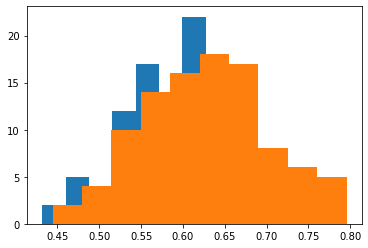

In [69]:
plt.hist(pd.Series(blue_recalls))
plt.hist(pd.Series(green_recalls))

In [70]:
ks_2samp(green_recalls, blue_recalls)

KstestResult(statistic=0.32, pvalue=6.281176788972264e-05)

In [71]:
pd.Series(blue_recalls).mean(), pd.Series(green_recalls).mean(), pd.Series(red_recalls).mean()

(0.5881414624668633, 0.6282914148043014, 0.6266733863559213)

In [72]:
recall_score(pred_df.true, model_preds_f, pos_label = 'Bad'), recall_score(pred_df.true, model_preds_f, pos_label = 'Good')

(0.6317016317016317, 0.6209081309398099)

In [42]:
overall_preds = rocket_models[0].predict(original_test_X)
print(recall_score(pred_df.true, overall_preds, pos_label = 'Good'), recall_score(pred_df.true, overall_preds, pos_label = 'Bad'))

0.5772615276311158 0.6363636363636364


In [10]:
train_preproc_act_less, train_preproc_act_more = concat_proc_data_act(train_data)
test_preproc_act_less, test_preproc_act_more = concat_proc_data_act(test_data)

In [11]:
test_preproc_act_less_X, test_preproc_act_less_y = split_X_y(test_preproc_act_less)
test_preproc_act_more_X, test_preproc_act_more_y = split_X_y(test_preproc_act_more)

In [12]:
act_less_preds = model_preds(test_preproc_act_less_X)
act_more_preds = model_preds(test_preproc_act_more_X)

In [13]:
recall_score(test_preproc_act_less_y, act_less_preds, pos_label = 'Bad'), recall_score(test_preproc_act_less_y, act_less_preds, pos_label = 'Good')

(0.6142857142857143, 0.6227208976157083)

In [14]:
recall_score(test_preproc_act_more_y, act_more_preds, pos_label = 'Bad'), recall_score(test_preproc_act_more_y, act_more_preds, pos_label = 'Good')

(0.6484018264840182, 0.6190812720848057)

In [23]:
train_preproc_sleep_less, train_preproc_sleep_more = concat_proc_data_sleep(train_data)
test_preproc_sleep_less, test_preproc_sleep_more = concat_proc_data_sleep(test_data)

test_preproc_sleep_less_X, test_preproc_sleep_less_y = split_X_y(test_preproc_sleep_less)
test_preproc_sleep_more_X, test_preproc_sleep_more_y = split_X_y(test_preproc_sleep_more)

sleep_less_preds = model_preds(test_preproc_sleep_less_X)
sleep_more_preds = model_preds(test_preproc_sleep_more_X)

In [24]:
recall_score(test_preproc_sleep_less_y, sleep_less_preds, pos_label = 'Bad'), recall_score(test_preproc_sleep_less_y, sleep_less_preds, pos_label = 'Good')

(0.6536796536796536, 0.6609918578830496)

In [25]:
recall_score(test_preproc_sleep_more_y, sleep_more_preds, pos_label = 'Bad'), recall_score(test_preproc_sleep_more_y, sleep_more_preds, pos_label = 'Good')

(0.6060606060606061, 0.5845637583892618)